In [1]:
import pandas as pd

df = pd.read_csv("../data/data_for_modelling.csv")

Before: (135231, 14)
After: (135206, 14)


,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner,1,3650,12,3,14,not_intact,male
1,1,Owner Surrender,Normal,Dog,Dachshund,Tricolor,Transfer,1,3650,4,2,15,not_intact,male
2,1,Public Assist,Injured,Dog,Shetland Sheepdog,Brown/White,Return to Owner,1,5840,11,5,9,not_intact,male
3,1,Stray,Aged,Dog,Labrador Retriever/Pit Bull,Black/White,Return to Owner,1,5475,11,5,14,not_intact,female
4,1,Stray,Normal,Dog,Miniature Schnauzer Mix,Black/Gray,Return to Owner,1,5475,11,4,15,intact,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135226,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135227,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135228,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135229,1,Stray,Normal,Cat,Domestic Shorthair,Black,Transfer,0,365,5,4,12,unknown,unknown


In [2]:
df_sampled = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_sampled

,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,1,Stray,Normal,Dog,Pug/Beagle,Tan/White,Adoption,0,180,6,0,13,intact,male
1,1,Stray,Normal,Cat,Domestic Shorthair Mix,Black/White,Adoption,0,60,10,3,12,intact,male
2,1,Stray,Sick,Cat,Domestic Shorthair,Flame Point,Adoption,1,60,7,4,12,intact,female
3,2,Owner Surrender,Normal,Dog,Australian Cattle Dog Mix,White/Brown,Transfer,1,2190,4,5,12,not_intact,female
4,1,Stray,Normal,Dog,Labrador Retriever,Black/White,Adoption,1,150,5,2,11,intact,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,1,Stray,Normal,Dog,Miniature Pinscher/Pug,Tricolor,Adoption,1,365,7,0,13,intact,female
13517,1,Stray,Normal,Cat,Domestic Shorthair Mix,Tortie,Transfer,1,30,6,1,10,intact,female
13518,1,Stray,Normal,Cat,Domestic Shorthair,Black,Adoption,1,30,7,1,16,not_intact,female
13519,1,Owner Surrender,Normal,Cat,Himalayan Mix,Tortie Point/White,Adoption,1,3650,2,6,10,not_intact,female


In [3]:
df_sampled.columns
print(df_sampled['outcome_type'].value_counts())

outcome_type
Adoption           6418
Transfer           4521
Return to Owner    1972
Euthanasia          452
Died                130
Other                28
Name: count, dtype: int64


In [4]:
data_for_modelling = df_sampled

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import pickle
from datetime import datetime

# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATES = [1, 2, 3, 4, 5]
TRAIN_SIZE = 0.6
VAL_SIZE = 0.5

# Random Forest hyperparameters
N_ESTIMATORS = 500  # Fixed - not tuned (500 trees is a good balance)
MAX_DEPTH_VALUES = [1, 2, 3, 5, 8, 10, 15, 20] 
MAX_FEATURES_VALUES = ['sqrt', 'log2', 0.1, 0.3, 0.5, 0.7, 0.9, 1.0] 

print("="*80)
print("RANDOM FOREST PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION")
print("="*80)
print(f"\nConfiguration:")
print(f"  n_estimators: {N_ESTIMATORS} (fixed)")
print(f"  Random states: {RANDOM_STATES}")
print(f"  Train/Val/Test: {TRAIN_SIZE}/{(1-TRAIN_SIZE)*VAL_SIZE}/{(1-TRAIN_SIZE)*(1-VAL_SIZE)}")
print(f"  max_depth values: {MAX_DEPTH_VALUES}")
print(f"  max_features values: {MAX_FEATURES_VALUES}")
print(f"  Total combinations: {len(MAX_DEPTH_VALUES)} × {len(MAX_FEATURES_VALUES)} = {len(MAX_DEPTH_VALUES)*len(MAX_FEATURES_VALUES)}")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def encode_cyclical(X):
    """Transform cyclical features to sin/cos components."""
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    periods = [12, 7, 24]
    result = []
    
    for i, period in enumerate(periods):
        values = X[:, i]
        result.append(np.sin(2 * np.pi * values / period).reshape(-1, 1))
        result.append(np.cos(2 * np.pi * values / period).reshape(-1, 1))
    
    return np.hstack(result)

def get_cyclical_feature_names(transformer, input_features):
    """Generate feature names for cyclical encoding output."""
    names = []
    for feature in input_features:
        names.append(f'{feature}_sin')
        names.append(f'{feature}_cos')
    return np.array(names)

def create_preprocessor():
    """Create preprocessing pipeline."""
    onehot_ftrs = [
        'intake_type', 'intake_condition', 'animal_type', 'sex', 
        'intactness', 'breed', 'color', 'HasName'
    ]
    
    std_ftrs = ['visit_count', 'age_days_intake']
    
    cyclical_ftrs = ['intake_month_num', 'intake_weekday_num', 'intake_hour']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(
                sparse_output=False, 
                handle_unknown='ignore'
            ), onehot_ftrs),
            
            ('std', StandardScaler(), std_ftrs),
            
            ('cyclical', FunctionTransformer(
                encode_cyclical, 
                validate=False,
                feature_names_out=get_cyclical_feature_names
            ), cyclical_ftrs)
        ],
        verbose_feature_names_out=False
    )
    
    return preprocessor

def macro_f2_score(y_true, y_pred):
    """Calculate macro-averaged F2 score."""
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

def calculate_baseline(y_train, y_val, y_test):
    """Calculate baseline F2 by predicting most frequent class."""
    most_frequent = y_train.value_counts().idxmax()
    
    y_train_pred = np.full(len(y_train), most_frequent)
    y_val_pred = np.full(len(y_val), most_frequent)
    y_test_pred = np.full(len(y_test), most_frequent)
    
    return {
        'most_frequent_class': most_frequent,
        'train_f2': macro_f2_score(y_train, y_train_pred),
        'val_f2': macro_f2_score(y_val, y_val_pred),
        'test_f2': macro_f2_score(y_test, y_test_pred),
    }

# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

def tune_hyperparameters(X_train_prep, y_train, X_val_prep, y_val, random_state):
    """
    Test all hyperparameter combinations for Random Forest.
    Tune max_depth and max_features.
    Returns best model (already trained) and tuning results.
    """
    best_val_f2 = -np.inf
    best_model = None
    best_params = None
    
    tune_results = []
    
    total_combos = len(MAX_DEPTH_VALUES) * len(MAX_FEATURES_VALUES)
    print(f"\n  Testing {total_combos} combinations...")
    
    combo_num = 0
    
    # Test all combinations of max_depth and max_features
    for max_depth in MAX_DEPTH_VALUES:
        for max_features in MAX_FEATURES_VALUES:
            combo_num += 1
            
            # Format depth for display
            depth_str = f"{max_depth}" if max_depth is not None else "None"
            # Format max_features for display
            if isinstance(max_features, str):
                feat_str = max_features
            elif max_features is None:
                feat_str = "None"
            else:
                feat_str = f"{max_features:.2f}"
            
            print(f"    [{combo_num}/{total_combos}] Testing depth={depth_str}, max_feat={feat_str}...", 
                  end='', flush=True)
            
            # Train Random Forest
            clf = RandomForestClassifier(
                n_estimators=N_ESTIMATORS,
                max_depth=max_depth,
                max_features=max_features,
                class_weight='balanced',
                random_state=random_state,
                n_jobs=-1  # Use all cores
            )
            
            clf.fit(X_train_prep, y_train)
            
            # Evaluate
            y_train_pred = clf.predict(X_train_prep)
            y_val_pred = clf.predict(X_val_prep)
            
            train_f2 = macro_f2_score(y_train, y_train_pred)
            val_f2 = macro_f2_score(y_val, y_val_pred)
            
            print(f" Train F2={train_f2:.4f}, Val F2={val_f2:.4f}", flush=True)
            
            # Store results
            tune_results.append({
                'max_depth': max_depth,
                'max_features': max_features,
                'train_f2': train_f2,
                'val_f2': val_f2,
            })
            
            # Track best model
            if val_f2 > best_val_f2:
                best_val_f2 = val_f2
                best_model = clf
                best_params = {'max_depth': max_depth, 'max_features': max_features}
    
    # Format best params for display
    depth_str = f"{best_params['max_depth']}" if best_params['max_depth'] is not None else "None"
    if isinstance(best_params['max_features'], str):
        feat_str = best_params['max_features']
    elif best_params['max_features'] is None:
        feat_str = "None"
    else:
        feat_str = f"{best_params['max_features']:.2f}"
    
    print(f"\n  ✓ Best: depth={depth_str}, max_feat={feat_str}, Val F2={best_val_f2:.4f}")
    
    return best_model, best_params, tune_results

# ============================================================================
# MAIN EXPERIMENT
# ============================================================================

def run_experiment(data_for_modelling, random_state):
    """Run complete experiment for one random state."""
    
    print(f"\n{'='*80}")
    print(f"Random State: {random_state}")
    print(f"{'='*80}")
    
    # Separate features and target
    y = data_for_modelling['outcome_type']
    X = data_for_modelling.drop(columns=['outcome_type'])
    
    # Split data
    X_train, X_other, y_train, y_other = train_test_split(
        X, y, train_size=TRAIN_SIZE, stratify=y, random_state=random_state, shuffle=True
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_other, y_other, train_size=VAL_SIZE, stratify=y_other, random_state=random_state, shuffle=True
    )
    
    print(f"\nData splits: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    
    # Calculate baseline
    baseline = calculate_baseline(y_train, y_val, y_test)
    print(f"\nBaseline (predicting '{baseline['most_frequent_class']}'):")
    print(f"  Train F2: {baseline['train_f2']:.4f}")
    print(f"  Val F2:   {baseline['val_f2']:.4f}")
    print(f"  Test F2:  {baseline['test_f2']:.4f}")
    
    # Class distribution
    print(f"\nClass distribution:")
    for cls in sorted(y_train.unique()):
        count = sum(y_train == cls)
        pct = 100 * count / len(y_train)
        print(f"  {cls:20s}: {count:4d} ({pct:5.1f}%)")
    
    # Preprocess
    preprocessor = create_preprocessor()
    preprocessor.fit(X_train)
    
    X_train_prep = preprocessor.transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    feature_names = preprocessor.get_feature_names_out()
    print(f"\nFeatures after preprocessing: {len(feature_names)}")
    
    # Tune hyperparameters (returns best model already trained)
    best_model, best_params, tune_results = tune_hyperparameters(
        X_train_prep, y_train, X_val_prep, y_val, random_state
    )
    
    # Get predictions from best model (no retraining)
    y_train_pred = best_model.predict(X_train_prep)
    y_val_pred = best_model.predict(X_val_prep)
    y_test_pred = best_model.predict(X_test_prep)
    
    # Calculate final scores
    train_f2 = macro_f2_score(y_train, y_train_pred)
    val_f2 = macro_f2_score(y_val, y_val_pred)
    test_f2 = macro_f2_score(y_test, y_test_pred)
    
    print(f"\nFinal Macro F2 Scores:")
    print(f"  Train: {train_f2:.4f} (baseline: {baseline['train_f2']:.4f}, Δ: +{train_f2-baseline['train_f2']:.4f})")
    print(f"  Val:   {val_f2:.4f} (baseline: {baseline['val_f2']:.4f}, Δ: +{val_f2-baseline['val_f2']:.4f})")
    print(f"  Test:  {test_f2:.4f} (baseline: {baseline['test_f2']:.4f}, Δ: +{test_f2-baseline['test_f2']:.4f})")
    
    # Return results
    return {
        'random_state': random_state,
        'best_model': best_model,
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'best_params': best_params,
        'tune_results': tune_results,
        
        # Original data
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        
        # Preprocessed data
        'X_train_prep': X_train_prep,
        'X_val_prep': X_val_prep,
        'X_test_prep': X_test_prep,
        
        # Predictions
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred,
        'y_test_pred': y_test_pred,
        
        # Scores
        'train_f2': train_f2,
        'val_f2': val_f2,
        'test_f2': test_f2,
        'baseline': baseline,
    }

# ============================================================================
# RUN ALL EXPERIMENTS
# ============================================================================

all_results = []

for rs in RANDOM_STATES:
    result = run_experiment(data_for_modelling, rs)
    all_results.append(result)

# ============================================================================
# AGGREGATE RESULTS
# ============================================================================

print("\n" + "="*80)
print("AGGREGATE RESULTS")
print("="*80)

test_f2_scores = [r['test_f2'] for r in all_results]

print(f"\nTest Macro F2 Scores:")
print(f"  Mean: {np.mean(test_f2_scores):.4f}")
print(f"  Std:  {np.std(test_f2_scores):.4f}")
print(f"  Min:  {np.min(test_f2_scores):.4f}")
print(f"  Max:  {np.max(test_f2_scores):.4f}")

baseline_test = np.mean([r['baseline']['test_f2'] for r in all_results])
print(f"\nBaseline Test F2: {baseline_test:.4f}")
print(f"Improvement: +{np.mean(test_f2_scores) - baseline_test:.4f}")

RANDOM FOREST PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION

Configuration:
  n_estimators: 500 (fixed)
  Random states: [1, 2, 3, 4, 5]
  Train/Val/Test: 0.6/0.2/0.2
  max_depth values: [1, 2, 3, 5, 8, 10, 15, 20]
  max_features values: ['sqrt', 'log2', 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
  Total combinations: 8 × 8 = 64

Random State: 1

Data splits: Train=8112, Val=2704, Test=2705

Baseline (predicting 'Adoption'):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class distribution:
  Adoption            : 3851 ( 47.5%)
  Died                :   78 (  1.0%)
  Euthanasia          :  271 (  3.3%)
  Other               :   17 (  0.2%)
  Return to Owner     : 1183 ( 14.6%)
  Transfer            : 2712 ( 33.4%)

Features after preprocessing: 978

  Testing 64 combinations...
    [1/64] Testing depth=1, max_feat=sqrt... Train F2=0.2933, Val F2=0.2628
    [2/64] Testing depth=1, max_feat=log2... Train F2=0.3402, Val F2=0.2970
    [3/64] Testing depth=1, max_feat=0.10... Train F2=0.2802, 


CREATING PLOTS

Tune summary shape: (64, 4)
✓ Saved: hyperparameter_plots_rf.png

BEST HYPERPARAMETERS

Best Random Forest (by avg validation F2):
  max_depth: 20
  max_features: 0.9
  Train F2: 0.9453
  Val F2: 0.3761


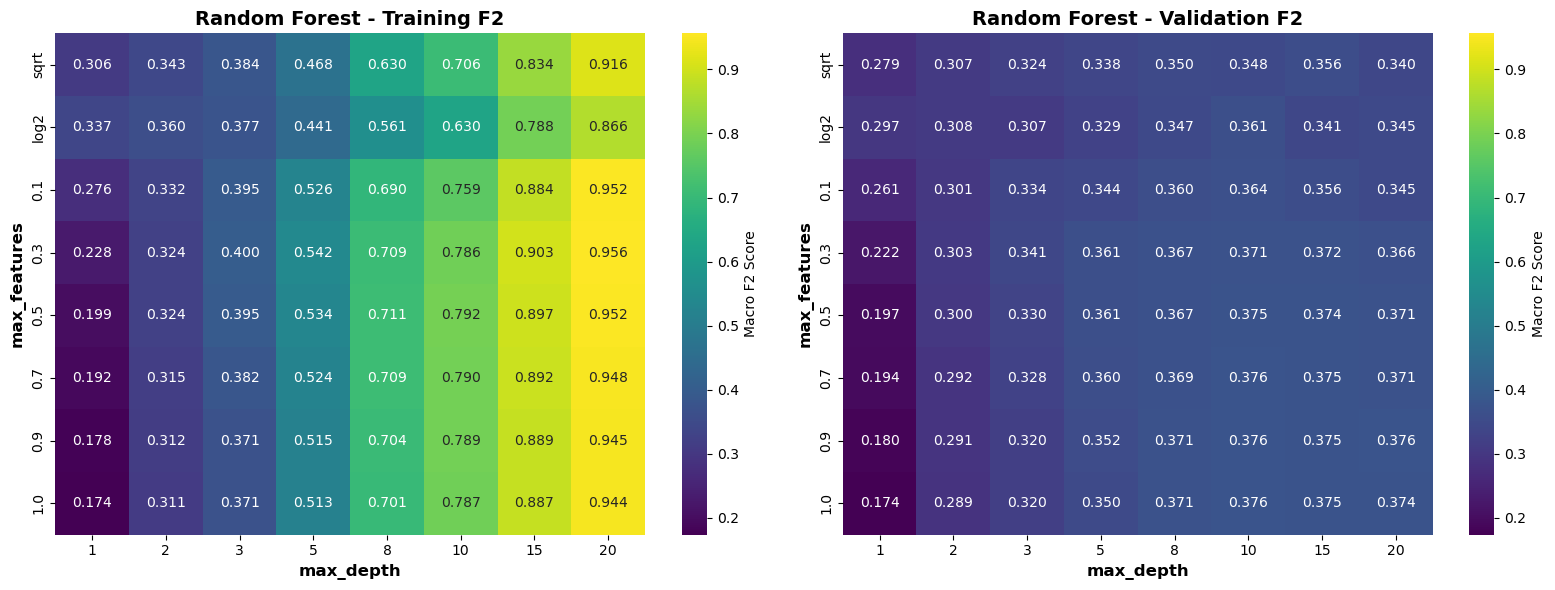

In [5]:
# ============================================================================
# CREATE PLOTS
# ============================================================================

print(f"\n{'='*80}")
print("CREATING PLOTS")
print(f"{'='*80}")

# Aggregate tuning results
all_tune_data = []
for result in all_results:
    for tune_result in result['tune_results']:
        all_tune_data.append(tune_result)

tune_df = pd.DataFrame(all_tune_data)

# Group by hyperparameters and calculate mean
tune_summary = tune_df.groupby(['max_depth', 'max_features']).agg({
    'train_f2': 'mean',
    'val_f2': 'mean',
}).reset_index()

print(f"\nTune summary shape: {tune_summary.shape}")

# Create pivot tables for heatmaps
# Convert to strings with explicit categorical ordering to fix axis sorting

# Define explicit order for max_depth (as it appears in MAX_DEPTH_VALUES)
depth_order = [str(d) if d is not None else "None" for d in MAX_DEPTH_VALUES]
# Define explicit order for max_features (as it appears in MAX_FEATURES_VALUES)
features_order = [str(f) if isinstance(f, str) or f is None else f"{f:.1f}" for f in MAX_FEATURES_VALUES]

# Convert to strings
tune_summary['max_features_str'] = tune_summary['max_features'].apply(
    lambda x: str(x) if isinstance(x, str) or x is None else f"{x:.1f}"
)
tune_summary['max_depth_str'] = tune_summary['max_depth'].apply(
    lambda x: str(x) if x is not None else "None"
)

# Convert to categorical with explicit ordering
tune_summary['max_features_str'] = pd.Categorical(
    tune_summary['max_features_str'], 
    categories=features_order, 
    ordered=True
)
tune_summary['max_depth_str'] = pd.Categorical(
    tune_summary['max_depth_str'], 
    categories=depth_order, 
    ordered=True
)

# Now pivot with proper ordering
train_pivot = tune_summary.pivot(index='max_features_str', columns='max_depth_str', values='train_f2')
val_pivot = tune_summary.pivot(index='max_features_str', columns='max_depth_str', values='val_f2')

# Determine common color scale
vmin = min(train_pivot.min().min(), val_pivot.min().min())
vmax = max(train_pivot.max().max(), val_pivot.max().max())

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Training F2
sns.heatmap(train_pivot, ax=axes[0], cmap='viridis', vmin=vmin, vmax=vmax,
            annot=True, fmt='.3f', cbar_kws={'label': 'Macro F2 Score'})
axes[0].set_title('Random Forest - Training F2', fontsize=14, fontweight='bold')
axes[0].set_xlabel('max_depth', fontsize=12, fontweight='bold')
axes[0].set_ylabel('max_features', fontsize=12, fontweight='bold')
# Tick labels are now in correct order from categorical data

# Heatmap 2: Validation F2
sns.heatmap(val_pivot, ax=axes[1], cmap='viridis', vmin=vmin, vmax=vmax,
            annot=True, fmt='.3f', cbar_kws={'label': 'Macro F2 Score'})
axes[1].set_title('Random Forest - Validation F2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('max_depth', fontsize=12, fontweight='bold')
axes[1].set_ylabel('max_features', fontsize=12, fontweight='bold')
# Tick labels are now in correct order from categorical data

plt.tight_layout()
plt.savefig('../figures/hyperparameter_plots_rf.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: hyperparameter_plots_rf.png")

# ============================
# BEST MODEL (by val F2)
# ============================
best_row = tune_summary.loc[tune_summary['val_f2'].idxmax()]
best_depth = best_row['max_depth']
best_features = best_row['max_features']
best_val_f2 = best_row['val_f2']
best_train_f2 = best_row['train_f2']

print("\n" + "="*80)
print("BEST HYPERPARAMETERS")
print("="*80)
print(f"\nBest Random Forest (by avg validation F2):")
print(f"  max_depth: {best_depth}")
print(f"  max_features: {best_features}")
print(f"  Train F2: {best_train_f2:.4f}")
print(f"  Val F2: {best_val_f2:.4f}")

In [7]:
best_row = tune_summary.loc[tune_summary['val_f2'].idxmax()]

print(best_row)

max_depth                 20
max_features             0.9
train_f2            0.945296
val_f2              0.376126
max_features_str         0.9
max_depth_str             20
Name: 60, dtype: object


In [8]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

print(f"\n{'='*80}")
print("SAVING RESULTS")
print(f"{'='*80}")

final_results = {
    'all_results': all_results,
    'config': {
        'model': 'RandomForest',
        'n_estimators': N_ESTIMATORS,
        'random_states': RANDOM_STATES,
        'max_depth_values': [str(d) if d is not None else "None" for d in MAX_DEPTH_VALUES],
        'max_features_values': [str(f) for f in MAX_FEATURES_VALUES],
    },
    'test_scores': {
        'mean': np.mean(test_f2_scores),
        'std': np.std(test_f2_scores),
        'all': test_f2_scores,
    },
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

output_file = '../results/pipeline_results_rf.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(final_results, f)

print(f"\n✓ Saved to: {output_file}")
print(f"\nSaved components:")
print(f"  • 5 best models (one per random state)")
print(f"  • All data splits (original and preprocessed)")
print(f"  • Feature names")
print(f"  • All predictions (for confusion matrix)")
print(f"  • Hyperparameter tuning results ({len(MAX_DEPTH_VALUES)*len(MAX_FEATURES_VALUES)} combinations × 5 states)")
print(f"  • Preprocessor objects")

print(f"\n{'='*80}")
print("PIPELINE COMPLETE!")
print(f"{'='*80}")


SAVING RESULTS

✓ Saved to: pipeline_results_rf.pkl

Saved components:
  • 5 best models (one per random state)
  • All data splits (original and preprocessed)
  • Feature names
  • All predictions (for confusion matrix)
  • Hyperparameter tuning results (64 combinations × 5 states)
  • Preprocessor objects

PIPELINE COMPLETE!


In [3]:
import pickle
import pandas as pd
import numpy as np

# ============================================================================
# LOAD SAVED RANDOM FOREST RESULTS
# ============================================================================
output_file = '../results/pipeline_results_rf.pkl'

with open(output_file, 'rb') as f:
    final_results = pickle.load(f)

all_results = final_results['all_results']

# ============================================================================
# BUILD TUNING SUMMARY ACROSS RANDOM STATES
# ============================================================================
rows = []

for res in all_results:
    rs = res['random_state']
    for tr in res['tune_results']:
        rows.append({
            'random_state': rs,
            'max_depth': tr['max_depth'],
            'max_features': tr['max_features'],
            'val_f2': tr['val_f2'],
        })

tune_df = pd.DataFrame(rows)

# Aggregate: mean & std of val_f2 for each (max_depth, max_features)
tune_summary = (
    tune_df
    .groupby(['max_depth', 'max_features'], as_index=False)
    .agg(
        mean_val_f2=('val_f2', 'mean'),
        std_val_f2=('val_f2', 'std'),
        n_runs=('val_f2', 'size')
    )
)

# ============================================================================
# FIND BEST HYPERPARAMETERS (BY MEAN VAL F2 ACROSS RUNS)
# ============================================================================
best_row = tune_summary.loc[tune_summary['mean_val_f2'].idxmax()]

print("Best Random Forest hyperparameters (by mean validation F2 across runs):")
print(f"  max_depth    : {best_row['max_depth']}")
print(f"  max_features : {best_row['max_features']}")
print(f"  Mean Val F2  : {best_row['mean_val_f2']:.4f}")
print(f"  Std  Val F2  : {best_row['std_val_f2']:.4f}")
print(f"  Runs used    : {int(best_row['n_runs'])}")

print(
    f"\nValidation F2 (mean ± std): "
    f"{best_row['mean_val_f2']:.4f} ± {best_row['std_val_f2']:.4f}"
)


Best Random Forest hyperparameters (by mean validation F2 across runs):
  max_depth    : 20
  max_features : 0.9
  Mean Val F2  : 0.3761
  Std  Val F2  : 0.0061
  Runs used    : 5

Validation F2 (mean ± std): 0.3761 ± 0.0061
